This is the walkthrough of the book [Little Learner](https://www.amazon.com/Little-Learner-Straight-Line-Learning-ebook/dp/B0BCDKRPTJ).


In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%matplotlib inline

`l2_loss` calculates the loss of target given xs and corresponding ys.
`line` represents, well, a line `mx + b`.

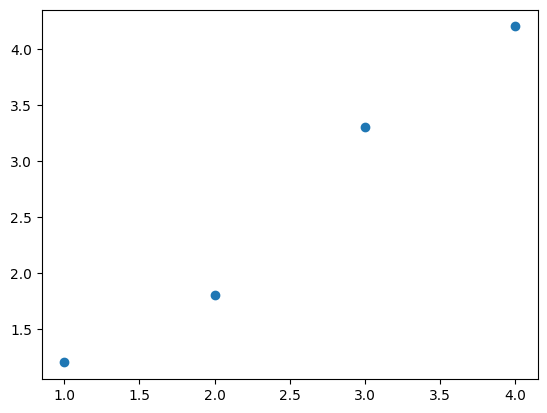

In [3]:
line_xs = np.array([2.0, 1.0, 4.0, 3.0])
line_ys =np.array([1.8, 1.2, 4.2, 3.3])
plt.scatter(line_xs, line_ys);

In [4]:
def l2_loss(target, xs: np.ndarray, ys: np.ndarray):
    def calculate_loss(params: np.ndarray) -> float:
        actual_ys = target(xs, params)
        return np.sum((actual_ys - ys) ** 2)

    return calculate_loss

def line(xs, params: np.ndarray):
    m, b = params
    return m * xs + b


l2_loss(line, xs=line_xs, ys=line_ys)(np.array([0, 0]))

33.21

We have a loss 33.21. That's pretty substantial. Let's improve that.

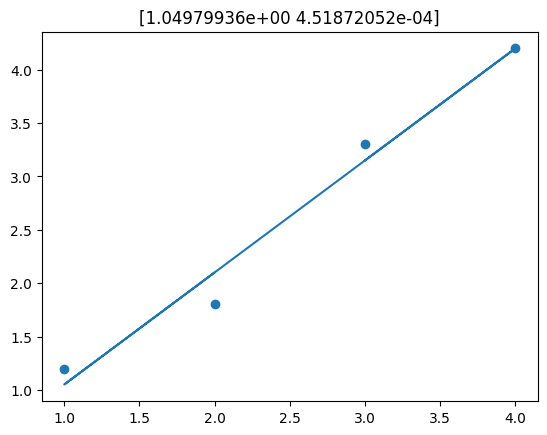

array([1.04979936e+00, 4.51872052e-04])

In [5]:
def learn(target, learning_rates, xs, ys, delta=0.0001, num_iterations=1000):
    # initial params
    params = np.array([0.0, 0.0])
    for i in range(num_iterations):
        loss = l2_loss(target, xs, ys)(params)
        change = np.array([0.0, 0.0])
        # we calculate partial derivatives and update each param
        # using learning_rate
        for j, value in enumerate(params):
            learning_params = params.copy()
            learning_params[j] += delta
            next_loss = l2_loss(target, xs, ys)(learning_params)
            # loss_rate is a gradient
            # we slide the gradient at each point to find the
            # better-fitted params
            loss_rate = (next_loss - loss) / delta
            change[j] -= loss_rate * learning_rates[j]
        params += change
    plt.scatter(line_xs, line_ys)
    plt.plot(line_xs, line(line_xs, params))
    plt.title(f'{params}')
    plt.show()
    return params

learn(line, learning_rates=np.array([0.01, 0.01]), xs=line_xs, ys=line_ys)



Now the line is well-fitted.

In [6]:
def plane(xs, params: np.ndarray):
    # xs is a tensor of tensor_1 (xs=[[0, 0], [1, 1])
    # @ is a dot product
    return params[0] @ xs + params[1]

We can use `plane` in `learn`. Actually let's rename `learn` to `gradient_descent`, because that's what it is.

In [7]:
gradient_descent = learn

Let's extract calculation of partial derivatives to the separate function `gradient` and add `sample_size`
We calculate gradient using random `sample_size` data points at each step. This kind of gradient descent is called stochastic gradient descent.

Stochastic is a fancy word for "random process".

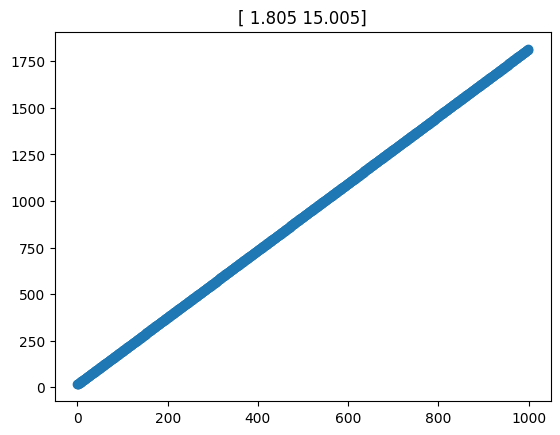

In [63]:
import itertools

def l2_loss_gradient(target, xs, ys, params, delta=0.0001, sample_size=None):
    gs = []
    if sample_size is None:
        indexes = np.arange(0, len(xs))
    else:
        indexes = np.random.randint(0, len(xs), sample_size)
        
    ranges = []
    k = 5
    for a_param in params:
        # calculate gradient near the `params` values
        ranges.append(np.linspace(a_param - 0.01, a_param + 0.01, k))
    calc_loss = l2_loss(target, xs[indexes], ys[indexes])
    results_sample = np.zeros((k,) * len(params))
    for i, param_sample in enumerate(itertools.product(*ranges)):
        product = 1
        reversed_index = []
        for dim in reversed(range(len(params))):
            index = (i // product) % k
            reversed_index.append(index)
            product *= k
        value = calc_loss(param_sample)
        index = tuple(reversed(reversed_index))
        results_sample[index] = value
    gradients = np.gradient(results_sample, *ranges)
    return np.array([g[(k // 2 - 1,)* len(params)] for g in gradients])

    loss = calc_loss(params)
    for j, value in enumerate(params):
        learning_params = params.copy()
        learning_params[j] += delta
        next_loss = calc_loss(learning_params)
        # loss_rate is a gradient
        # we slide on the gradient at each point to find the
        # better-fitted params
        loss_rate = (next_loss - loss) / delta
        gs.append(loss_rate)
    return np.array(gs)


def gradient_descent(target, xs, ys, learning_rates, sample_size=None, delta=0.0001, num_iterations=1000, verbose=False):
    # initial params
    params = np.array([0.0, 0.0])
    for i in range(num_iterations):
        # we calculate partial derivatives and update each param
        # using learning_rate
        gs = l2_loss_gradient(target, xs, ys, params, sample_size=sample_size, delta=delta)
        base_velocity = -gs * learning_rates
        params += base_velocity
        if verbose:
            print(f'i={i} gs={gs}, params={params}')
    return params

        
def line_plot(xs, ys, learned_params):
    plt.scatter(xs, ys)
    plt.plot(xs, line(xs, learned_params))
    plt.title(f'{learned_params}')
    plt.show()
    
    
def build_loss_plot(target, xs, ys):
    plot_xs = np.linspace(-20, 20, 1000)
    objective_fn = l2_loss(target, xs, ys)
    plot_ys_list = []
    for m in plot_xs:
        params = [m, 0]
        loss = objective_fn(params)
        plot_ys_list.append(loss)
    plot_ys = np.array(plot_ys_list)
    plt.plot(plot_xs, plot_ys)
    plt.title(f'loss(m)')
    plt.show()
    

learned_params = gradient_descent(line, 
                                  np.arange(0, 1000), 
                                  np.arange(0, 1000) * 1.8 + 15, 
                                  sample_size=15,
                                  learning_rates=np.array([1e-8, 1e-2]),
                                  num_iterations=3000,
                                  verbose=False)
line_plot(np.arange(0, 1000), np.arange(0, 1000) * 1.8 + 15, learned_params)


l2_loss is a quadratic function

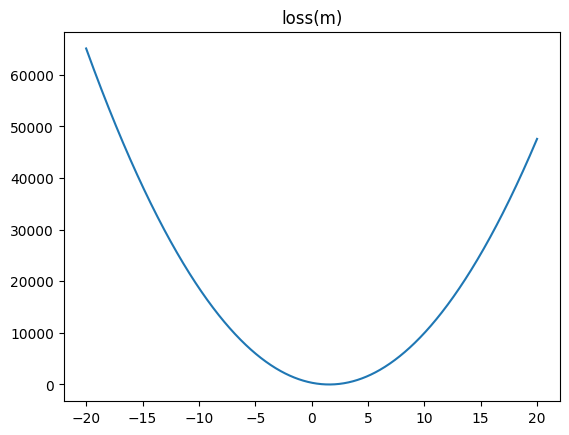

In [9]:
build_loss_plot(line, np.arange(0, 8), np.arange(0, 8) * 1.5 + 0.32)

Let's add some momentum for a gradient descent.
Velocity is a change part of params (-gs * learning_rates)
We take a previous velocity in params and add some part of it to current velocity.


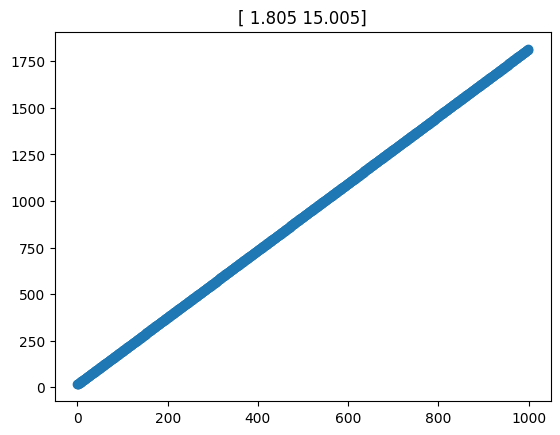

In [65]:
def gradient_descent(target, xs, ys, learning_rates, initial_params=None, velocity_coeff=0, sample_size=None, delta=0.0001, num_iterations=1000, verbose=False):
    # initial params
    if initial_params is None:
        params = np.array([0.0, 0.0])
    prev_velocity = np.array([0.0, 0.0])
    for i in range(num_iterations):
        # we calculate partial derivatives and update each param
        # using learning_rate
        gs = l2_loss_gradient(target, xs, ys, params, sample_size=sample_size, delta=delta)
        base_velocity = -gs * learning_rates
        prev_velocity_part = velocity_coeff * prev_velocity
        velocity = base_velocity + prev_velocity_part
        params += velocity
        if verbose:
            print(f'i={i} gs={gs}, params={params}')
        prev_velocity = velocity
    return params


learned_params = gradient_descent(line, 
                                  np.arange(0, 1000), 
                                  np.arange(0, 1000) * 1.8 + 15, 
                                  sample_size=15,
                                  learning_rates=np.array([1e-8, 1e-2]),
                                  num_iterations=3000,
                                  velocity_coeff=0.9,
                                  verbose=False)
line_plot(np.arange(0, 1000), np.arange(0, 1000) * 1.8 + 15, learned_params)

`smooth`, well, smoothes values.

In [11]:
def smooth(decay_rate, average, g):
    # TODO implement gradient descent with smooth
    return decay_rate * average + (1 - decay_rate) * g

If `decay_rate` == 0.9, then new values only contribute 0.1 of their value to the historical average

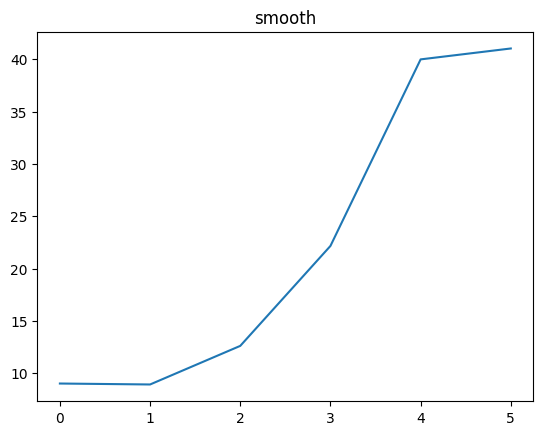

In [12]:
def plot_smooth(decay_rate, values):
    averages = [0.0]
    for a_value in values:
        averages.append(smooth(decay_rate, averages[-1], a_value))
    plt.plot(np.arange(len(values)), np.array(averages[1:]))
    plt.title('smooth')
    plt.show()

plot_smooth(0.9, [90.1, 8.1, 45.8, 108.1, 200.4, 50.4])

Difference between original values is almost 200, and difference between smooth averages is about 30.

Each value contributes lesser and lesser value to the average with the passing of time

In [ ]:


def rectify(s):
    # we are using np.maximum, so `rectify` also works on arrays
    return np.maximum(s, 0)

def linear(t, params):
    return params[0] @ t + params[1]

def relu(t, params):
    # REctifying Linear Unit
    # params[0] is an array of weights
    # params[1] is a bias
    return rectify(linear(t, params))

def A(*values):
    return np.array(values)

def half_strip(x, params):
    x = A(x)
    return relu(x, [params[0], params[1]]) - relu(x, [params[0], params[2]])


def plot_fn(fn, xs, title=None):
    plt.plot(xs, fn(xs))
    plt.title(title or getattr(fn, '__name__', None) or str(fn))
    
    
import functools
    
    
plot_fn(functools.partial(half_strip, params=[A(1.0), -1.0, -1.5]),
        xs=np.linspace(0, 10, 1000),
        title='half strip')

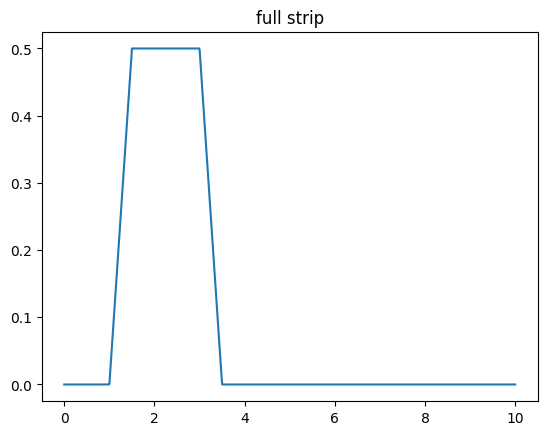

In [37]:
def full_strip(x, params):
    return half_strip(x, params[:3]) - half_strip(x, params[3:])

plot_fn(functools.partial(full_strip, params=[A(1.0), -1.0, -1.5, A(1.0), -3.0, -3.5]),
        xs=np.linspace(0, 10, 1000),
        title='full strip')

We can approximate any function using `half_strip` and `full_strip`

We can build neural networks with the layers of neurons. `relu` is an example of neuron.

Layer consists of `m` neurons, takes a tensor of shape `(n)`, and returns a tensor of shape `(m)`

`relu` can act as a layer. We can rephrase the comment in `relu` about the nature of `params`

In [ ]:
def relu(t, params):
    # params[0] is a tensor(m, n), where m is number of neurons and n is a size of input
    # params[1] is a tensor(m)
    # code of relu/rectify/linear doesn't need changes, because numpy is awesome and reshapes arrays to a common shape
    return rectify(linear(t, params))

Let's implement a neural network.

In [67]:
Tensor1 = np.ndarray
Layer = list[(np.ndarray, Tensor1)]
    

def relu_neural_network(layers: list[Layer], input_: Tensor1) -> Tensor1:
    """Put an `input_` through neural network consisting of `layers`"""
    output = input_
    for a_layer in layers:
        output = relu(output, a_layer)
    return output


def make_layers(shapes: list[((int, int), (int,))]) -> list[Layer]:
    layers = []
    for weights_shape, bias_shape in shapes:
        # 0 for mean and 2 / weights_shape[-1] is a good choice to avoid instability and vanishing problems 
        # instability: when output of nn becomes too large
        # vanishing: when output of nn becomes too small
        weights = np.random.normal(0, 2 / weights_shape[-1], weights_shape)
        bias = np.zeros(bias_shape)
        layers.append([weights, bias])
    return layers


def run_network(input_):
    # network with two layers, first layer has 10 neurons, second layer has 3 neurons
    # network expects input of shape [5]
    model = functools.partial(relu_neural_network, layers=make_layers([((10, 5), (10,)), ((3, 10), (3,))]))
    return model(input_=input_)
    
    
# rand(5), because network expects input of shape [5]
print(run_network(np.random.rand(5)))


[0.25657902 0.0993336  0.        ]


We have a lot of zeroes in the output, because of the `rectify` which zeroes out all negative values.
Let's run gradient descent on some data.

In [ ]:
def run_gradient_descent_on_nn():
    layers = make_layers([((10, 5), (10,)), ((3, 10), (3,))])
    learned_params = gradient_descent(line, 
                                  np.arange(0, 1000), 
                                  np.arange(0, 1000) * 1.8 + 15, 
                                  initial_params=layers,
                                  sample_size=15,
                                  learning_rates=np.array([1e-2, 1e-2]),
                                  num_iterations=3000,
                                  verbose=False)
    print(learned_params)
    


run_gradient_descent_on_nn()